# 🎯 双均线交叉策略（DualMAStrategy）— 回测与绩效分析

本 Notebook 完整演示以下流程：

1. **数据准备** — 从本地 DuckDB 拉取个股日线 + 沪深300 基准数据
2. **策略配置** — 实例化 `DualMAStrategy`，设置短/长均线窗口
3. **运行回测** — 使用 `BacktestEngine` 事件驱动引擎
4. **绩效分析** — 使用 `PerformanceAnalyzer` 生成完整报告
5. **可视化** — 净值曲线、回撤、K 线 + 买卖点、月度热力图

## 1. 导入库与全局配置

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 项目模块
from stockquant.data.data_manager import DataManager
from stockquant.data.database import Database
from stockquant.strategy.examples import DualMAStrategy
from stockquant.backtest.engine import BacktestEngine
from stockquant.analysis.performance import PerformanceAnalyzer
from stockquant.visualization.plot import PlotEngine

# 显示设置
pd.set_option("display.max_columns", 30)
pd.set_option("display.width", 160)
plt.rcParams["figure.figsize"] = (14, 5)
plt.rcParams["font.sans-serif"] = ["SimHei", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False

print("✅ 所有模块导入成功")

## 2. 加载数据

从本地 DuckDB 查询回测标的日线数据和沪深300基准数据。

> **提示：** 如果本地数据库为空，请先运行数据更新器：
> ```bash
> cd stockquant/data && python3 -m updater --mode hs300 --start-date 2020-01-01
> cd stockquant/data && python3 -m updater --mode benchmark --start-date 2020-01-01
> ```

In [ ]:
# ---------- 回测参数 ----------
STOCK_CODES = ["600519", "000858", "601318"]   # 贵州茅台、五粮液、中国平安
START_DATE  = "2020-01-01"
END_DATE    = "2025-12-31"
BENCHMARK   = "000300"  # 沪深300

# ---------- 从本地数据库读取个股日线 ----------
dm = DataManager()

stock_data: dict[str, pd.DataFrame] = {}
for code in STOCK_CODES:
    df = dm.fetch_daily(code, start_date=START_DATE, end_date=END_DATE)
    if df.empty:
        print(f"⚠️ {code} 无数据，请先运行数据更新器")
    else:
        df["date"] = pd.to_datetime(df["date"])
        stock_data[code] = df
        print(f"✅ {code}: {len(df)} 条日线  [{df['date'].min().date()} ~ {df['date'].max().date()}]")

# ---------- 读取基准指数（复用 DataManager 的数据库连接，避免 DuckDB 多连接冲突）----------
benchmark_df = dm.db.query(
    "SELECT * FROM index_daily WHERE code = ? AND date >= ? AND date <= ? ORDER BY date",
    [BENCHMARK, START_DATE, END_DATE],
)
benchmark_df["date"] = pd.to_datetime(benchmark_df["date"])
print(f"📊 基准 {BENCHMARK}: {len(benchmark_df)} 条")
benchmark_df.head(3)

## 3. 配置并运行回测

使用 `DualMAStrategy` 双均线交叉策略：
- **短均线窗口** $MA_{short} = 5$（默认）
- **长均线窗口** $MA_{long} = 20$（默认）
- 金叉（短均线上穿长均线）→ 买入目标仓位 20%
- 死叉（短均线下穿长均线）→ 清仓卖出

In [47]:
# ---- 1. 实例化策略（可自定义参数）----
strategy = DualMAStrategy()
strategy.set_params(
    short_window=10,
    long_window=50,
    position_pct=0.4,       # 每只股票目标仓位 40%
    stop_loss_pct=-0.05,    # 止损设置：当亏损达到 5% 时卖出
    take_profit_pct=10.0    # 止盈设置：当盈利10倍时卖出
)

# ---- 2. 创建回测引擎 ----
engine = BacktestEngine()
engine.set_strategy(strategy)
engine.set_data(stock_data)
engine.set_date_range(start_date=START_DATE, end_date=END_DATE)

# ---- 3. 运行回测 ----
result = engine.run()

# ---- 4. 查看基础结果 ----
print(result)
print()
for k, v in result.summary().items():
    print(f"  {k}: {v}")

2026-02-18 05:29:31.684 | INFO     | stockquant.backtest.engine:set_data:78 | 已加载 3 只标的，1455 个交易日
2026-02-18 05:29:31.685 | INFO     | stockquant.backtest.engine:run:104 | ====== 回测开始 ======
2026-02-18 05:29:37.287 | INFO     | stockquant.backtest.engine:run:144 | ====== 回测结束 ======


BacktestResult(return=11.48%, trades=71, final_value=1,114,838)

  初始资金: 1,000,000
  最终市值: 1,114,838
  总收益率: 11.48%
  总交易次数: 71


## 4. 绩效分析

使用 `PerformanceAnalyzer` 计算完整指标：

| 类别 | 指标 |
|------|------|
| 收益 | 总收益率、年化收益、Alpha、Beta |
| 风险 | 最大回撤、最大回撤天数、年化波动率、VaR(95%) |
| 风险调整 | 夏普比率 $SR = \frac{\bar{R} - R_f}{\sigma_R}\sqrt{252}$、索提诺比率、卡玛比率 |
| 交易 | 总交易次数、买入/卖出次数、总佣金 |

In [36]:
# 构建基准日收益率序列
bm_returns = benchmark_df["close"].pct_change().fillna(0).tolist() if not benchmark_df.empty else []

# 创建绩效分析器
analyzer = PerformanceAnalyzer(
    equity_curve=result.equity_curve,
    trade_log=result.trade_log,
    daily_returns=result.daily_returns,
    benchmark_returns=bm_returns,
)

# 生成完整报告
report = analyzer.full_report()

# 以表格形式展示
report_df = pd.DataFrame(list(report.items()), columns=["指标", "值"])
report_df.style.set_properties(**{"text-align": "left"})

2026-02-18 05:17:37.580 | INFO     | stockquant.analysis.performance:full_report:193 | 绩效报告:
2026-02-18 05:17:37.580 | INFO     | stockquant.analysis.performance:full_report:195 |   总收益率: 11.48%
2026-02-18 05:17:37.581 | INFO     | stockquant.analysis.performance:full_report:195 |   年化收益率: 1.90%
2026-02-18 05:17:37.582 | INFO     | stockquant.analysis.performance:full_report:195 |   Alpha: -0.00%
2026-02-18 05:17:37.584 | INFO     | stockquant.analysis.performance:full_report:195 |   Beta: 0.29
2026-02-18 05:17:37.585 | INFO     | stockquant.analysis.performance:full_report:195 |   最大回撤: 39.15%
2026-02-18 05:17:37.585 | INFO     | stockquant.analysis.performance:full_report:195 |   最大回撤天数: 1182
2026-02-18 05:17:37.587 | INFO     | stockquant.analysis.performance:full_report:195 |   年化波动率: 35.90%
2026-02-18 05:17:37.588 | INFO     | stockquant.analysis.performance:full_report:195 |   VaR(95%): -0.0097
2026-02-18 05:17:37.588 | INFO     | stockquant.analysis.performance:full_report:195 |

,指标,值
0,总收益率,11.48%
1,年化收益率,1.90%
2,Alpha,-0.00%
3,Beta,0.29
4,最大回撤,39.15%
5,最大回撤天数,1182
6,年化波动率,35.90%
7,VaR(95%),-0.0097
8,夏普比率,-0.03
9,索提诺比率,-0.03


## 5. 可视化 — 净值曲线与回撤

/workspaces/stockQuant/stockquant/visualization/plot.py:70: UserWarning:

Glyph 31574 (\N{CJK UNIFIED IDEOGRAPH-7B56}) missing from font(s) DejaVu Sans.

/workspaces/stockQuant/stockquant/visualization/plot.py:70: UserWarning:

Glyph 30053 (\N{CJK UNIFIED IDEOGRAPH-7565}) missing from font(s) DejaVu Sans.

/workspaces/stockQuant/stockquant/visualization/plot.py:70: UserWarning:

Glyph 27818 (\N{CJK UNIFIED IDEOGRAPH-6CAA}) missing from font(s) DejaVu Sans.

/workspaces/stockQuant/stockquant/visualization/plot.py:70: UserWarning:

Glyph 28145 (\N{CJK UNIFIED IDEOGRAPH-6DF1}) missing from font(s) DejaVu Sans.

/workspaces/stockQuant/stockquant/visualization/plot.py:70: UserWarning:

Glyph 22522 (\N{CJK UNIFIED IDEOGRAPH-57FA}) missing from font(s) DejaVu Sans.

/workspaces/stockQuant/stockquant/visualization/plot.py:70: UserWarning:

Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from font(s) DejaVu Sans.

/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.

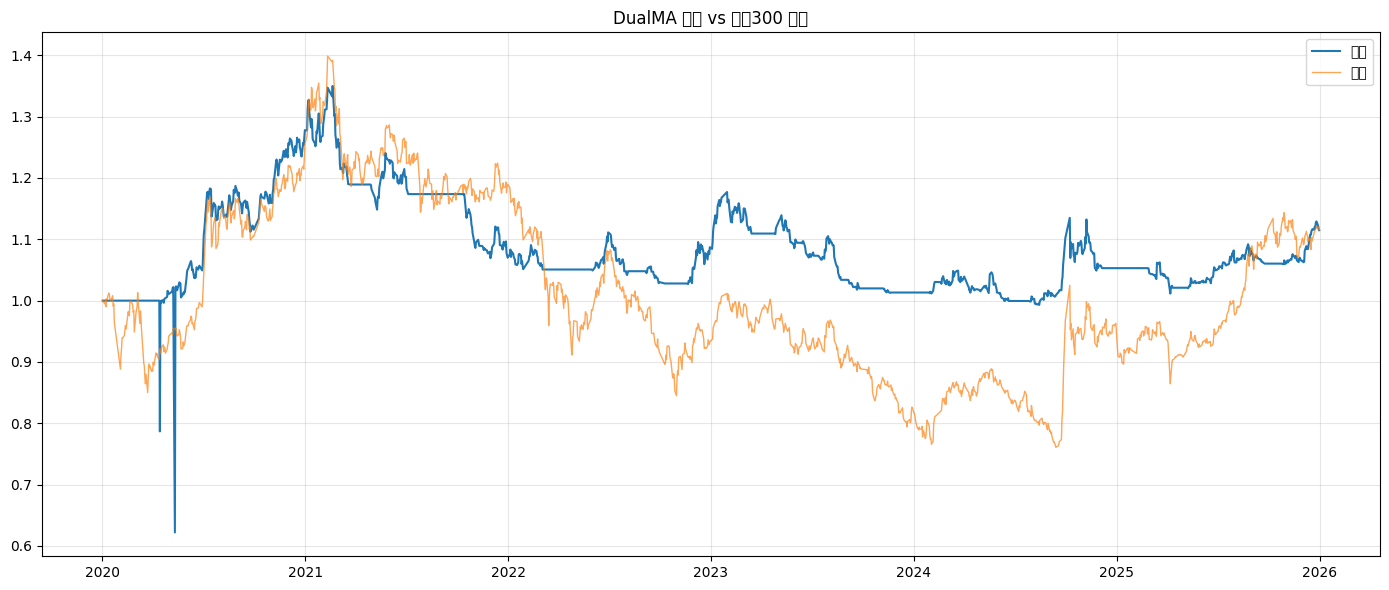

In [37]:
plot = PlotEngine(backend="matplotlib")

# 5.1 策略净值 vs 基准净值
plot.plot_equity_curve(
    result.equity_curve,
    benchmark=benchmark_df,
    title="DualMA 策略 vs 沪深300 基准",
)

/workspaces/stockQuant/stockquant/visualization/plot.py:117: UserWarning:

Glyph 31574 (\N{CJK UNIFIED IDEOGRAPH-7B56}) missing from font(s) DejaVu Sans.

/workspaces/stockQuant/stockquant/visualization/plot.py:117: UserWarning:

Glyph 30053 (\N{CJK UNIFIED IDEOGRAPH-7565}) missing from font(s) DejaVu Sans.

/workspaces/stockQuant/stockquant/visualization/plot.py:117: UserWarning:

Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from font(s) DejaVu Sans.

/workspaces/stockQuant/stockquant/visualization/plot.py:117: UserWarning:

Glyph 25764 (\N{CJK UNIFIED IDEOGRAPH-64A4}) missing from font(s) DejaVu Sans.

/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from font(s) DejaVu Sans.

/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 25764 (\N{CJK UNIFIED IDEOGRAPH-64A4}) missing from font(s) DejaVu Sans.



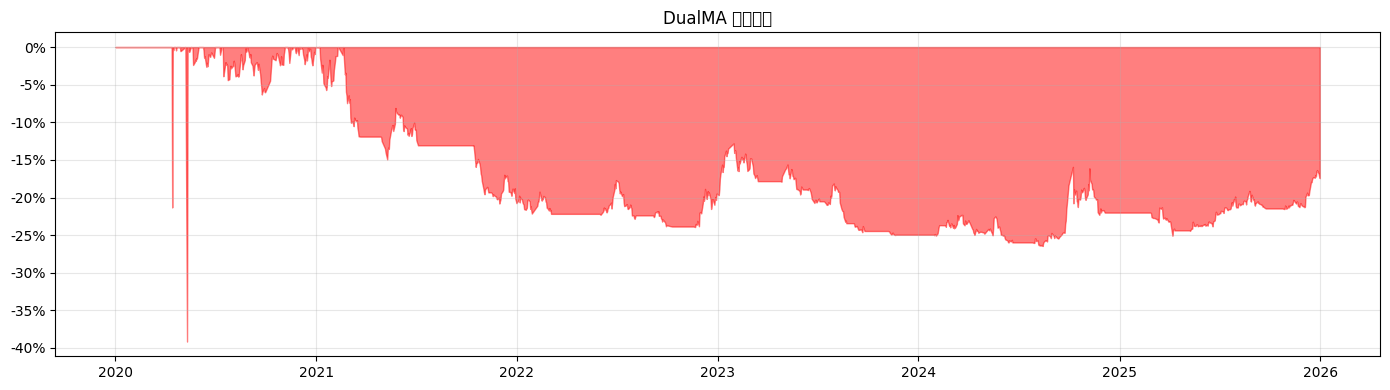

In [38]:
# 5.2 回撤曲线
plot.plot_drawdown(result.equity_curve, title="DualMA 策略回撤")

## 6. K 线图 + 买卖点标注

选择一只股票，用 Plotly 绘制交互式 K 线图并标注策略的买卖点。

In [39]:
# 选取第一只股票展示 K 线
show_code = STOCK_CODES[2]
show_df = stock_data[show_code].copy()

# 过滤出该股票的交易记录
trades_df = result.trade_log
if not trades_df.empty:
    code_trades = trades_df[trades_df["code"] == show_code].copy()
    code_trades["date"] = pd.to_datetime(code_trades["date"])
else:
    code_trades = pd.DataFrame()

# 用 Plotly 绘制 K 线（含买卖点）
plot_plotly = PlotEngine(backend="plotly")
plot_plotly.plot_kline(show_df, trades=code_trades, title=f"{show_code} K线 + DualMA 买卖信号")

## 7. 交易明细分析

In [40]:
# 查看所有交易记录
if not result.trade_log.empty:
    print(f"总交易次数: {len(result.trade_log)}")
    print(f"总佣金支出: {result.trade_log['commission'].sum():,.2f} 元\n")

    # 按股票统计
    summary = result.trade_log.groupby(["code", "direction"]).agg(
        次数=("quantity", "count"),
        总股数=("quantity", "sum"),
        平均价=("price", "mean"),
        佣金=("commission", "sum"),
    ).round(2)
    display(summary)

    print("\n最近 10 笔交易:")
    display(result.trade_log.tail(10))
else:
    print("⚠️ 回测期间无交易发生，请检查策略参数或数据范围")

总交易次数: 71
总佣金支出: 19,818.97 元



次数    总股数      平均价        佣金
code   direction                              
000858 buy        14   1400  2998.86   1049.60
       sell       14   1400  3079.21   5388.61
601318 buy        22  68800   137.85   2323.25
       sell       21  66200   136.32  11057.51


最近 10 笔交易:


,date,code,direction,quantity,price,commission
61,2025-03-03,601318,sell,2900,138.92160,503.590800
62,2025-03-07,601318,buy,2900,141.82308,102.821733
63,2025-03-11,000858,buy,100,2532.56502,63.314126
64,2025-04-08,601318,sell,2900,136.78588,495.848815
65,2025-04-11,000858,sell,100,2466.26758,308.283448
66,2025-05-09,601318,buy,2800,142.32408,99.626856
67,2025-07-21,000858,buy,100,2384.15880,59.603970
68,2025-09-10,601318,sell,2800,157.17502,550.112570
69,2025-09-24,000858,sell,100,2371.67714,296.459642
70,2025-10-27,601318,buy,2600,159.46830,103.654395


## 8. 月度收益热力图

/workspaces/stockQuant/stockquant/visualization/plot.py:215: UserWarning:

Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.

/workspaces/stockQuant/stockquant/visualization/plot.py:215: UserWarning:

Glyph 31574 (\N{CJK UNIFIED IDEOGRAPH-7B56}) missing from font(s) DejaVu Sans.

/workspaces/stockQuant/stockquant/visualization/plot.py:215: UserWarning:

Glyph 30053 (\N{CJK UNIFIED IDEOGRAPH-7565}) missing from font(s) DejaVu Sans.

/workspaces/stockQuant/stockquant/visualization/plot.py:215: UserWarning:

Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.

/workspaces/stockQuant/stockquant/visualization/plot.py:215: UserWarning:

Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from font(s) DejaVu Sans.

/workspaces/stockQuant/stockquant/visualization/plot.py:215: UserWarning:

Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from font(s) DejaVu Sans.

/workspaces/stockQuant/stockquant/visualization/plot.py:215: UserWarni

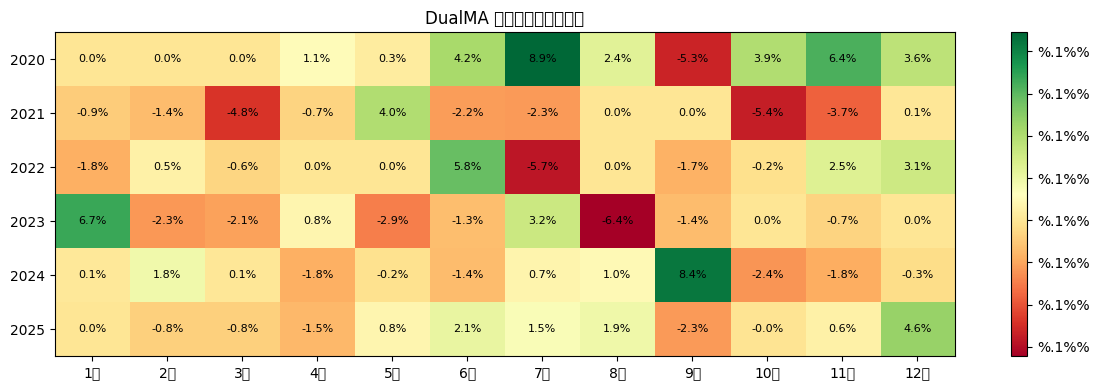

In [41]:
# 将日收益率转为带日期索引的 Series 以绘制月度热力图
if not result.equity_curve.empty and len(result.daily_returns) > 0:
    daily_ret_series = pd.Series(
        result.daily_returns,
        index=pd.to_datetime(result.equity_curve["date"]),
    )
    plot.plot_monthly_heatmap(daily_ret_series, title="DualMA 策略月度收益热力图")
else:
    print("⚠️ 无权益数据，无法绘制热力图")

## 9. 参数敏感性分析

遍历不同的短/长均线窗口组合，观察策略表现如何随参数变化。

In [42]:
# 参数网格
short_windows = [3, 5, 10, 15, 20]
long_windows  = [20, 30, 40, 60, 90]

param_results = []

for sw in short_windows:
    for lw in long_windows:
        if sw >= lw:
            continue  # 短窗口必须 < 长窗口
        s = DualMAStrategy()
        s.set_params(short_window=sw, long_window=lw, position_pct=0.2)

        e = BacktestEngine()
        e.set_strategy(s)
        e.set_data(stock_data)
        e.set_date_range(start_date=START_DATE, end_date=END_DATE)
        r = e.run()

        pa = PerformanceAnalyzer(r.equity_curve, r.trade_log, r.daily_returns)
        param_results.append({
            "short": sw,
            "long": lw,
            "total_return": pa.total_return(),
            "annual_return": pa.annualized_return(),
            "max_drawdown": pa.max_drawdown(),
            "sharpe": pa.sharpe_ratio(),
            "trades": pa.trade_statistics().get("总交易次数", 0),
        })

param_df = pd.DataFrame(param_results).round(4)
param_df.sort_values("sharpe", ascending=False).head(10)

2026-02-18 05:20:10.244 | INFO     | stockquant.backtest.engine:set_data:78 | 已加载 3 只标的，1455 个交易日
2026-02-18 05:20:10.247 | INFO     | stockquant.backtest.engine:run:104 | ====== 回测开始 ======
2026-02-18 05:20:15.603 | INFO     | stockquant.backtest.engine:run:144 | ====== 回测结束 ======
2026-02-18 05:20:15.613 | INFO     | stockquant.backtest.engine:set_data:78 | 已加载 3 只标的，1455 个交易日
2026-02-18 05:20:15.614 | INFO     | stockquant.backtest.engine:run:104 | ====== 回测开始 ======
2026-02-18 05:20:20.942 | INFO     | stockquant.backtest.engine:run:144 | ====== 回测结束 ======
2026-02-18 05:20:20.956 | INFO     | stockquant.backtest.engine:set_data:78 | 已加载 3 只标的，1455 个交易日
2026-02-18 05:20:20.958 | INFO     | stockquant.backtest.engine:run:104 | ====== 回测开始 ======
2026-02-18 05:20:26.281 | INFO     | stockquant.backtest.engine:run:144 | ====== 回测结束 ======
2026-02-18 05:20:26.295 | INFO     | stockquant.backtest.engine:set_data:78 | 已加载 3 只标的，1455 个交易日
2026-02-18 05:20:26.296 | INFO     | stockquant.ba

,short,long,total_return,annual_return,max_drawdown,sharpe,trades
0,3,20,0.0757,0.0127,0.1985,-0.1263,105
20,20,30,0.0481,0.0082,0.1879,-0.1693,51
21,20,40,0.0395,0.0067,0.1945,-0.1742,33
17,15,40,0.0395,0.0067,0.1959,-0.1747,33
12,10,40,0.0368,0.0063,0.1975,-0.1764,37
6,5,30,0.0280,0.0048,0.1952,-0.1906,59
16,15,30,0.0267,0.0046,0.1919,-0.1959,43
7,5,40,0.0088,0.0015,0.1975,-0.2119,51
11,10,30,0.0130,0.0022,0.1917,-0.2120,53
13,10,60,0.0008,0.0001,0.1952,-0.2239,35


/tmp/ipykernel_4447/1161234201.py:22: UserWarning:

Glyph 38271 (\N{CJK UNIFIED IDEOGRAPH-957F}) missing from font(s) DejaVu Sans.

/tmp/ipykernel_4447/1161234201.py:22: UserWarning:

Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from font(s) DejaVu Sans.

/tmp/ipykernel_4447/1161234201.py:22: UserWarning:

Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from font(s) DejaVu Sans.

/tmp/ipykernel_4447/1161234201.py:22: UserWarning:

Glyph 31383 (\N{CJK UNIFIED IDEOGRAPH-7A97}) missing from font(s) DejaVu Sans.

/tmp/ipykernel_4447/1161234201.py:22: UserWarning:

Glyph 21475 (\N{CJK UNIFIED IDEOGRAPH-53E3}) missing from font(s) DejaVu Sans.

/tmp/ipykernel_4447/1161234201.py:22: UserWarning:

Glyph 30701 (\N{CJK UNIFIED IDEOGRAPH-77ED}) missing from font(s) DejaVu Sans.

/tmp/ipykernel_4447/1161234201.py:22: UserWarning:

Glyph 21442 (\N{CJK UNIFIED IDEOGRAPH-53C2}) missing from font(s) DejaVu Sans.

/tmp/ipykernel_4447/1161234201.py:22: UserWarning:

Glyph 25968 (\N{CJK UNIF

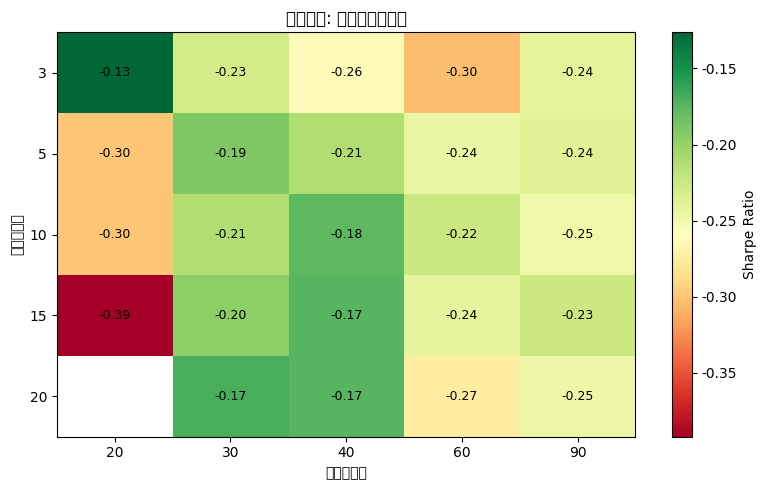

In [43]:
# 绘制参数-夏普比率热力图
pivot = param_df.pivot(index="short", columns="long", values="sharpe")

fig, ax = plt.subplots(figsize=(8, 5))
im = ax.imshow(pivot.values, cmap="RdYlGn", aspect="auto")
ax.set_xticks(range(len(pivot.columns)))
ax.set_xticklabels(pivot.columns)
ax.set_yticks(range(len(pivot.index)))
ax.set_yticklabels(pivot.index)
ax.set_xlabel("长均线窗口")
ax.set_ylabel("短均线窗口")
ax.set_title("参数搜索: 夏普比率热力图")

# 在每个格子中标注数值
for i in range(len(pivot.index)):
    for j in range(len(pivot.columns)):
        val = pivot.values[i, j]
        if not np.isnan(val):
            ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=9)

plt.colorbar(im, ax=ax, label="Sharpe Ratio")
plt.tight_layout()
plt.show()

## 10. 导出结果

将回测结果保存到本地文件，方便后续离线查看。

In [44]:
import os, json
from pathlib import Path

# 将结果导出到当前 Notebook 所在目录
cwd = Path.cwd()
if (cwd / "notebooks" / "dual_ma").exists():
    output_dir = cwd / "notebooks" / "dual_ma"
else:
    output_dir = cwd
output_dir = str(output_dir)
os.makedirs(output_dir, exist_ok=True)

# 1. 权益曲线 CSV
result.equity_curve.to_csv(f"{output_dir}/equity_curve.csv", index=False)

# 2. 交易明细 CSV
if not result.trade_log.empty:
    result.trade_log.to_csv(f"{output_dir}/trade_log.csv", index=False)

# 3. 绩效报告 JSON
with open(f"{output_dir}/performance_report.json", "w", encoding="utf-8") as f:
    json.dump(report, f, ensure_ascii=False, indent=2, default=str)

# 4. 参数搜索结果 CSV
param_df.to_csv(f"{output_dir}/param_search.csv", index=False)

print(f"✅ 结果已导出到: {output_dir}")
for fname in os.listdir(output_dir):
    fpath = os.path.join(output_dir, fname)
    size_kb = os.path.getsize(fpath) / 1024
    print(f"   📄 {fname}  ({size_kb:.1f} KB)")

✅ 结果已导出到: /workspaces/stockQuant/notebooks/dual_ma
   📄 equity_curve.csv  (79.6 KB)
   📄 param_search.csv  (1.0 KB)
   📄 dual_ma_backtest.ipynb  (589.5 KB)
   📄 performance_report.json  (0.4 KB)
   📄 trade_log.csv  (3.8 KB)
